In [1]:
#setup
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import gensim

sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from main import nlp_pipeline_result

In [3]:
"""
data_non_ner = nlp_pipeline_result(
    disable_ner=False,
    parameters={
        "remove_hashtag_word": True,
        "replace_politics": True,
        "replace_parties": True,
    }
)
data_non_ner['n_lemmas'] = data_non_ner['Lemmas'].str.split().str.len()

data_non_ner.to_csv('data/data.csv', index = False)
"""

'\ndata_non_ner = nlp_pipeline_result(\n    disable_ner=False,\n    parameters={\n        "remove_hashtag_word": True,\n        "replace_politics": True,\n        "replace_parties": True,\n    }\n)\ndata_non_ner[\'n_lemmas\'] = data_non_ner[\'Lemmas\'].str.split().str.len()\n\ndata_non_ner.to_csv(\'data/data.csv\', index = False)\n'

In [4]:
data = pd.read_csv('data/data.csv')

In [5]:
for i in range(0,50,10):
    display(data[i:i+10])

,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
0,El Centro de Robótica e Inteligencia Artificia...,El Centro de Robótica e Inteligencia Artificia...,411,177,José Luis Ábalos Meco,PSOE,Centro Robótica Inteligencia Artificial Alcáza...,22
1,Día de homenaje a los españoles deportados y f...,Día de homenaje a los españoles deportados y f...,770,326,José Luis Ábalos Meco,PSOE,homenaje español deportado fallecido campo con...,16
2,Mi agradecimiento a los interventores y apoder...,Mi agradecimiento a los interventores y apoder...,653,222,José Luis Ábalos Meco,PSOE,agradecimiento interventor apoderado represent...,14
3,Hemos autorizado las obras de un puente móvil ...,Hemos autorizado las obras de un puente móvil ...,167,77,José Luis Ábalos Meco,PSOE,autorizar obra puente móvil conexión ferroviar...,17
4,La estación de Santa Justa cumple 30 años con ...,La estación de Santa Justa cumple 30 años con ...,257,116,José Luis Ábalos Meco,PSOE,estación Santa Justa cumplir año millón usuari...,22
5,Se cumplen 142 años de la fundación del @PSOE ...,Se cumplen 142 años de la fundación del PSOE y...,421,211,José Luis Ábalos Meco,PSOE,cumplir año fundación PSOE seguir hablar timbr...,18
6,La llama de nuestro fundador Pablo Iglesias Po...,La llama de nuestro fundador Pablo Iglesias Po...,277,174,José Luis Ábalos Meco,PSOE,llamar fundador Pablo Iglesias Posse vivo año ...,20
7,Junto con los sindicatos @UGT_Comunica y @CCOO...,Junto con los sindicatos y compañeras y compañ...,352,136,José Luis Ábalos Meco,PSOE,sindicato compañera compañera clase trabajador...,12
8,Mi homenaje a los trabajadores y trabajadoras ...,Mi homenaje a los trabajadores y trabajadoras ...,602,254,José Luis Ábalos Meco,PSOE,homenaje trabajador trabajador respuesta pande...,14
9,"Reunido con el Secretario de @SRE_mx, @m_ebrar...",Reunido con el Secretario de para abordar los ...,175,91,José Luis Ábalos Meco,PSOE,reunido Secretario abordar proyecto Tren Maya ...,17


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
10,La Junta Electoral abre dos expedientes sancio...,La Junta Electoral abre dos expedientes sancio...,552,354,José Luis Ábalos Meco,PSOE,Junta Electoral abrir expediente sancionador A...,11
11,La Justicia recuerda a Vox que una querella ne...,La Justicia recuerda a Vox que una querella ne...,296,197,José Luis Ábalos Meco,PSOE,Justicia recordar Vox querella necesitar razón...,11
12,Una vez más se demuestra que la arquitectura e...,Una vez más se demuestra que la arquitectura e...,85,49,José Luis Ábalos Meco,PSOE,demostrar arquitectura español alto nivel cont...,18
13,Damos nuevos pasos para restablecer el tráfico...,Damos nuevos pasos para restablecer el tráfico...,185,83,José Luis Ábalos Meco,PSOE,dar paso restablecer tráfico ferroviario Almer...,16
14,Vamos a poner en marcha en #Linares un nuevo C...,Vamos a poner en marcha en un nuevo Centro de ...,146,98,José Luis Ábalos Meco,PSOE,marcha Centro Competencias Digitales crear pue...,9
15,"Mi agradecimiento al alcalde @JulioMillanjaen,...",Mi agradecimiento al alcalde por la acogida en...,121,59,José Luis Ábalos Meco,PSOE,agradecimiento alcalde acogida confirmar compr...,11
16,Seguimos apostando por la recuperación de nues...,Seguimos apostando por la recuperación de nues...,164,83,José Luis Ábalos Meco,PSOE,seguir apostar recuperación patrimonio históri...,11
17,Le he trasladado al Secretario de Transportes ...,Le he trasladado al Secretario de Transportes ...,385,143,José Luis Ábalos Meco,PSOE,trasladar Secretario Transportes Unidos dispos...,16
18,"Todo mi apoyo y solidaridad, @MarotoReyes. En ...","Todo mi apoyo y solidaridad, En un país democr...",689,258,José Luis Ábalos Meco,PSOE,apoyo solidaridad país democrático imposible a...,19
19,"Alejandro Morant: ""¿Alguien se cree que llegue...","Alejandro Morant: ""¿Alguien se cree que llegue...",180,129,José Luis Ábalos Meco,PSOE,Alejandro Morant Alguien creer llegar ministro...,11


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
20,"25 de abril, Día de les @cortsval. Una fecha l...","25 de abril, Día de les Una fecha llena de ref...",167,91,José Luis Ábalos Meco,PSOE,abril fecha lleno referencia histórico socieda...,18
21,"25 de abril de 1974, la Revolución de los Clav...","25 de abril de 1974, la Revolución de los Clav...",312,144,José Luis Ábalos Meco,PSOE,abril Revolución Claveles oir él Grândola Vila...,21
22,Seguimos cumpliendo con los compromisos para e...,Seguimos cumpliendo con los compromisos para e...,299,127,José Luis Ábalos Meco,PSOE,seguir cumplir compromiso desarrollo Corredor ...,16
23,‘El porqué de las palabras’(Francisco Brines. ...,‘El porqué de las palabras’(Francisco Brines. ...,138,60,José Luis Ábalos Meco,PSOE,porqué Brines Premio Cervantes poeta,5
24,Los demócratas creemos en la palabra pero no p...,Los demócratas creemos en la palabra pero no U...,1298,563,José Luis Ábalos Meco,PSOE,demócrata creer palabra Unidas normalizar ultr...,18
25,Este Gobierno invierte más en Extremadura. Hem...,Este Gobierno invierte más en Extremadura. Hem...,50,29,José Luis Ábalos Meco,PSOE,Gobierno invertir Extremadura licitar inversió...,12
26,Este verano ponemos en marcha en #Mérida un Ce...,Este verano ponemos en marcha en un Centro Tec...,93,55,José Luis Ábalos Meco,PSOE,verano poner marcha Centro Tecnológico Avanzad...,15
27,Tenemos que aislar a quienes siembran el odio ...,Tenemos que aislar a quienes siembran el odio ...,916,313,José Luis Ábalos Meco,PSOE,aislar sembrar odio señalar bala demócrata sol...,12
28,Con el proyecto de Acondicionamiento de la Ave...,Con el proyecto de Acondicionamiento de la Ave...,103,57,José Luis Ábalos Meco,PSOE,proyecto Acondicionamiento Avenida Martin Cara...,20
29,"Cumpliendo nuestros compromisos, hemos multipl...","Cumpliendo nuestros compromisos, hemos multipl...",100,65,José Luis Ábalos Meco,PSOE,cumplir compromiso multiplicar licitación inve...,17


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
30,Visitando la nueva Base de Mantenimiento de Re...,Visitando la nueva Base de Mantenimiento de Re...,94,52,José Luis Ábalos Meco,PSOE,visitar Base Mantenimiento Renfe Badajoz acoge...,18
31,"Hoy, he comprobado personalmente en Badajoz qu...","Hoy, he comprobado personalmente en Badajoz qu...",102,48,José Luis Ábalos Meco,PSOE,comprobar Badajoz ejecutado trabajo remodelaci...,10
32,⚪ Licitaremos antes del verano las obras de la...,⚪ Licitaremos antes del verano las obras de la...,72,47,José Luis Ábalos Meco,PSOE,Licitaremos verano obra variante Zafra Badajoz...,19
33,Seguimos recuperando nuestro patrimonio histór...,Seguimos recuperando nuestro patrimonio histór...,171,74,José Luis Ábalos Meco,PSOE,seguir recuperar patrimonio histórico reabrimo...,19
34,Damos un nuevo paso en la Alta Velocidad Madri...,Damos un nuevo paso en la Alta Velocidad Madri...,266,124,José Luis Ábalos Meco,PSOE,dar paso Alta Velocidad iniciar prueba sistema...,15
35,Reunido con el ministro marroquí de Infraestru...,Reunido con el ministro marroquí de Infraestru...,192,92,José Luis Ábalos Meco,PSOE,reunido ministro marroquí Infraestructura Tran...,19
36,🟣 @Renfe sigue avanzando en la implantación de...,🟣 sigue avanzando en la implantación de sus Ce...,108,57,José Luis Ábalos Meco,PSOE,avanzar implantación Centros Competencias Digi...,18
37,Cumplimos nuestro objetivo de financiar el tra...,Cumplimos nuestro objetivo de financiar el tra...,283,137,José Luis Ábalos Meco,PSOE,cumplir objetivo financiar transporte público ...,14
38,Esta tarde he acudido a la cita de @GVAsanitat...,Esta tarde he acudido a la cita de para recibi...,1236,395,José Luis Ábalos Meco,PSOE,acudir cita recibir vacuna AstraZeneca Valenci...,18
39,Mi saludo y reconocimiento a @facua que hoy ce...,Mi saludo y reconocimiento a que hoy celebra s...,420,122,José Luis Ábalos Meco,PSOE,saludo reconocimiento celebrar Asamblea agrade...,15


,Original Tweets,Parsed Tweets,Likes,Retweets,Author,Party,Lemmas,n_lemmas
40,Vamos a potenciar el tráfico ferroviario de me...,Vamos a potenciar el tráfico ferroviario de me...,203,107,José Luis Ábalos Meco,PSOE,potenciar tráfico ferroviario mercancía Plan M...,14
41,Iniciamos una nueva etapa en la historia de la...,Iniciamos una nueva etapa en la historia de la...,485,178,José Luis Ábalos Meco,PSOE,iniciar etapa historia estación Canfranc puest...,17
42,He recibido de mis compañeros y compañeras del...,He recibido de mis compañeros y compañeras del...,401,160,José Luis Ábalos Meco,PSOE,recibir compañero compañera enorme orgullo Pre...,17
43,Estamos comprometidos con el derecho a la #Viv...,Estamos comprometidos con el derecho a la Por ...,312,173,José Luis Ábalos Meco,PSOE,comprometido derecho ampliar mes carácter urge...,13
44,Los casi 7.000 Mill€ para la rehabilitación de...,Los casi 7.000 Mill€ para la rehabilitación de...,255,152,José Luis Ábalos Meco,PSOE,rehabilitación edificio regeneración Plan Recu...,15
45,El volumen de inversiones de @mitmagob incluid...,El volumen de inversiones de incluido en los e...,157,85,José Luis Ábalos Meco,PSOE,volumen inversión incluido contribuir año crec...,9
46,Avanzamos en la modernización y mejora de @rod...,Avanzamos en la modernización y mejora de el C...,120,56,José Luis Ábalos Meco,PSOE,avanzar modernización mejora Consejo Ministros...,18
47,Hemos autorizado las obras de mejora de la Est...,Hemos autorizado las obras de mejora de la Est...,69,37,José Luis Ábalos Meco,PSOE,autorizar obra mejora Estación Marítima cercan...,16
48,Seguimos trabajando en la primera de Ley de Vi...,Seguimos trabajando en la primera de Ley de Vi...,207,129,José Luis Ábalos Meco,PSOE,seguir trabajar Ley Vivienda país frenar subid...,15
49,Todo mi reconocimiento a los hombres y mujeres...,Todo mi reconocimiento a los hombres y mujeres...,136,75,José Luis Ábalos Meco,PSOE,reconocimiento hombre mujer integrar contribuc...,19


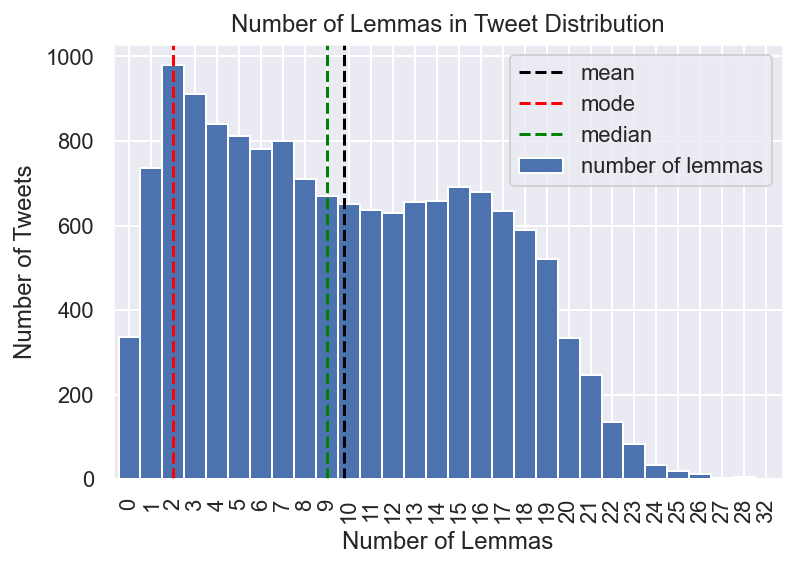

In [6]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar",width=1,label='number of lemmas')
plt.axvline(x = data['n_lemmas'].mean(),label='mean',color = 'black',linestyle = '--')
plt.axvline(x = data['n_lemmas'].mode()[0],label='mode',color = 'red',linestyle = '--')
plt.axvline(x = data['n_lemmas'].median(),label='median',color = 'green',linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [7]:
data = data[data['n_lemmas']>=3]
print('Number of Tweets in Dataframe after removing short tweets:', len(data))

Number of Tweets in Dataframe after removing short tweets: 12739


In [8]:
tweets_corpus = data["Lemmas"].tolist()
tweets_corpus = list(set(tweets_corpus))
tweets_corpus = [el.split() for el in tweets_corpus]

# display(tweets_corpus)

In [14]:
from gensim.corpora import Dictionary

token_dic = Dictionary(tweets_corpus)


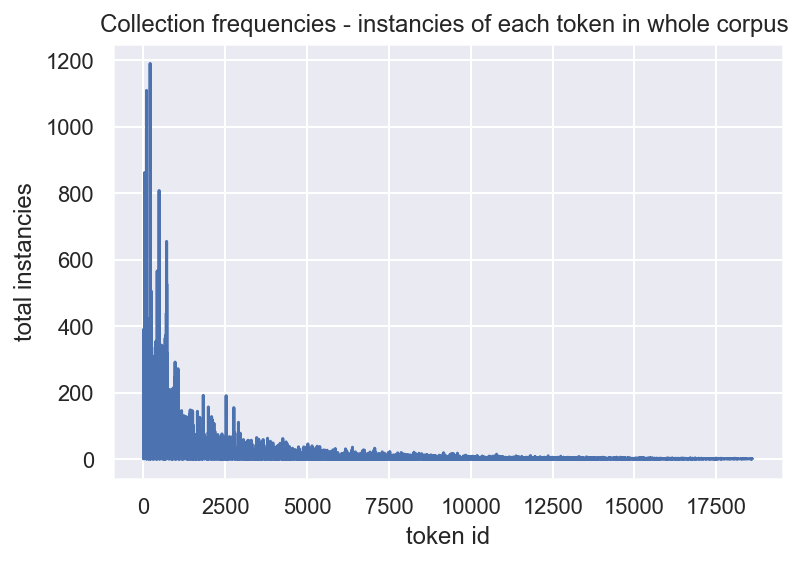

In [15]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.

collfreq = token_dic.cfs.items()
collfreq = sorted(collfreq) 
x, y = zip(*collfreq) 
plt.plot(x, y)
plt.title('Collection frequencies - instancies of each token in whole corpus ')
plt.xlabel('token id')
plt.ylabel('total instancies')
plt.show()

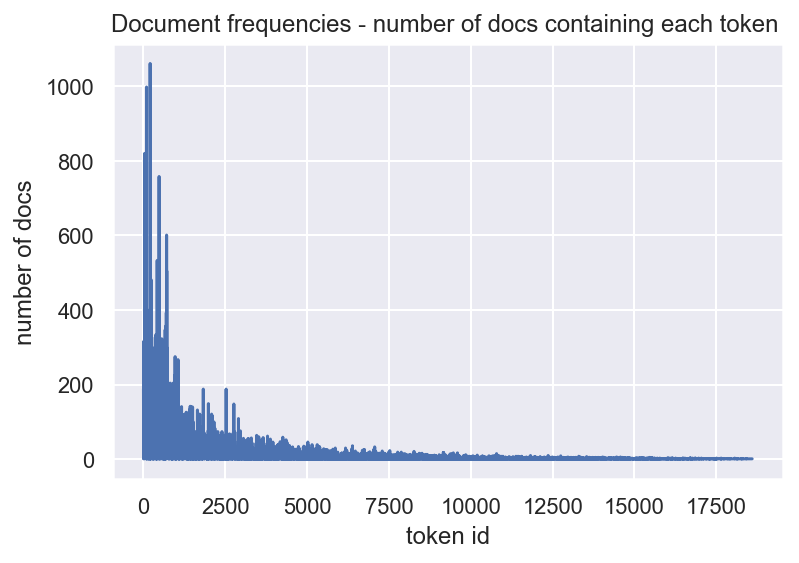

In [16]:
# Document frequencies: token_id -> how many documents contain this token


docfreq = token_dic.dfs.items()
docfreq = sorted(docfreq) 
j, k = zip(*docfreq) 
plt.plot(j, k)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()






In [17]:
#FILTER TOKEN DICTIONARY


no_below_list = [1,2,3,4,5,6,7,8,9,10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [0.002, 0.004, 0.006, 0.008] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

prev_dic = token_dic
prev_tokens = len(token_dic)


print('The dictionary contained', prev_tokens, 'terms')

for i in no_below_list:
    
    for j in no_above_list:
        
        token_dic.filter_extremes(no_below=i,no_above=j)
        
        n_tokens = len(token_dic)
        
        print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY


The dictionary contained 18602 terms
17588 terms |no_below =  1 | no_above =  0.002
17588 terms |no_below =  1 | no_above =  0.004
17588 terms |no_below =  1 | no_above =  0.006
17588 terms |no_below =  1 | no_above =  0.008
7745 terms |no_below =  2 | no_above =  0.002
7745 terms |no_below =  2 | no_above =  0.004
7745 terms |no_below =  2 | no_above =  0.006
7745 terms |no_below =  2 | no_above =  0.008
5221 terms |no_below =  3 | no_above =  0.002
5221 terms |no_below =  3 | no_above =  0.004
5221 terms |no_below =  3 | no_above =  0.006
5221 terms |no_below =  3 | no_above =  0.008
3908 terms |no_below =  4 | no_above =  0.002
3908 terms |no_below =  4 | no_above =  0.004
3908 terms |no_below =  4 | no_above =  0.006
3908 terms |no_below =  4 | no_above =  0.008
3126 terms |no_below =  5 | no_above =  0.002
3126 terms |no_below =  5 | no_above =  0.004
3126 terms |no_below =  5 | no_above =  0.006
3126 terms |no_below =  5 | no_above =  0.008
2577 terms |no_below =  6 | no_above = 

In [19]:
token_dic = prev_dic

# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

# tweets_corpus_bow

In [21]:
from gensim.models.wrappers import LdaMallet
import os

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
#mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=20,
    id2word=token_dic,
    alpha=5,
    iterations=100
)

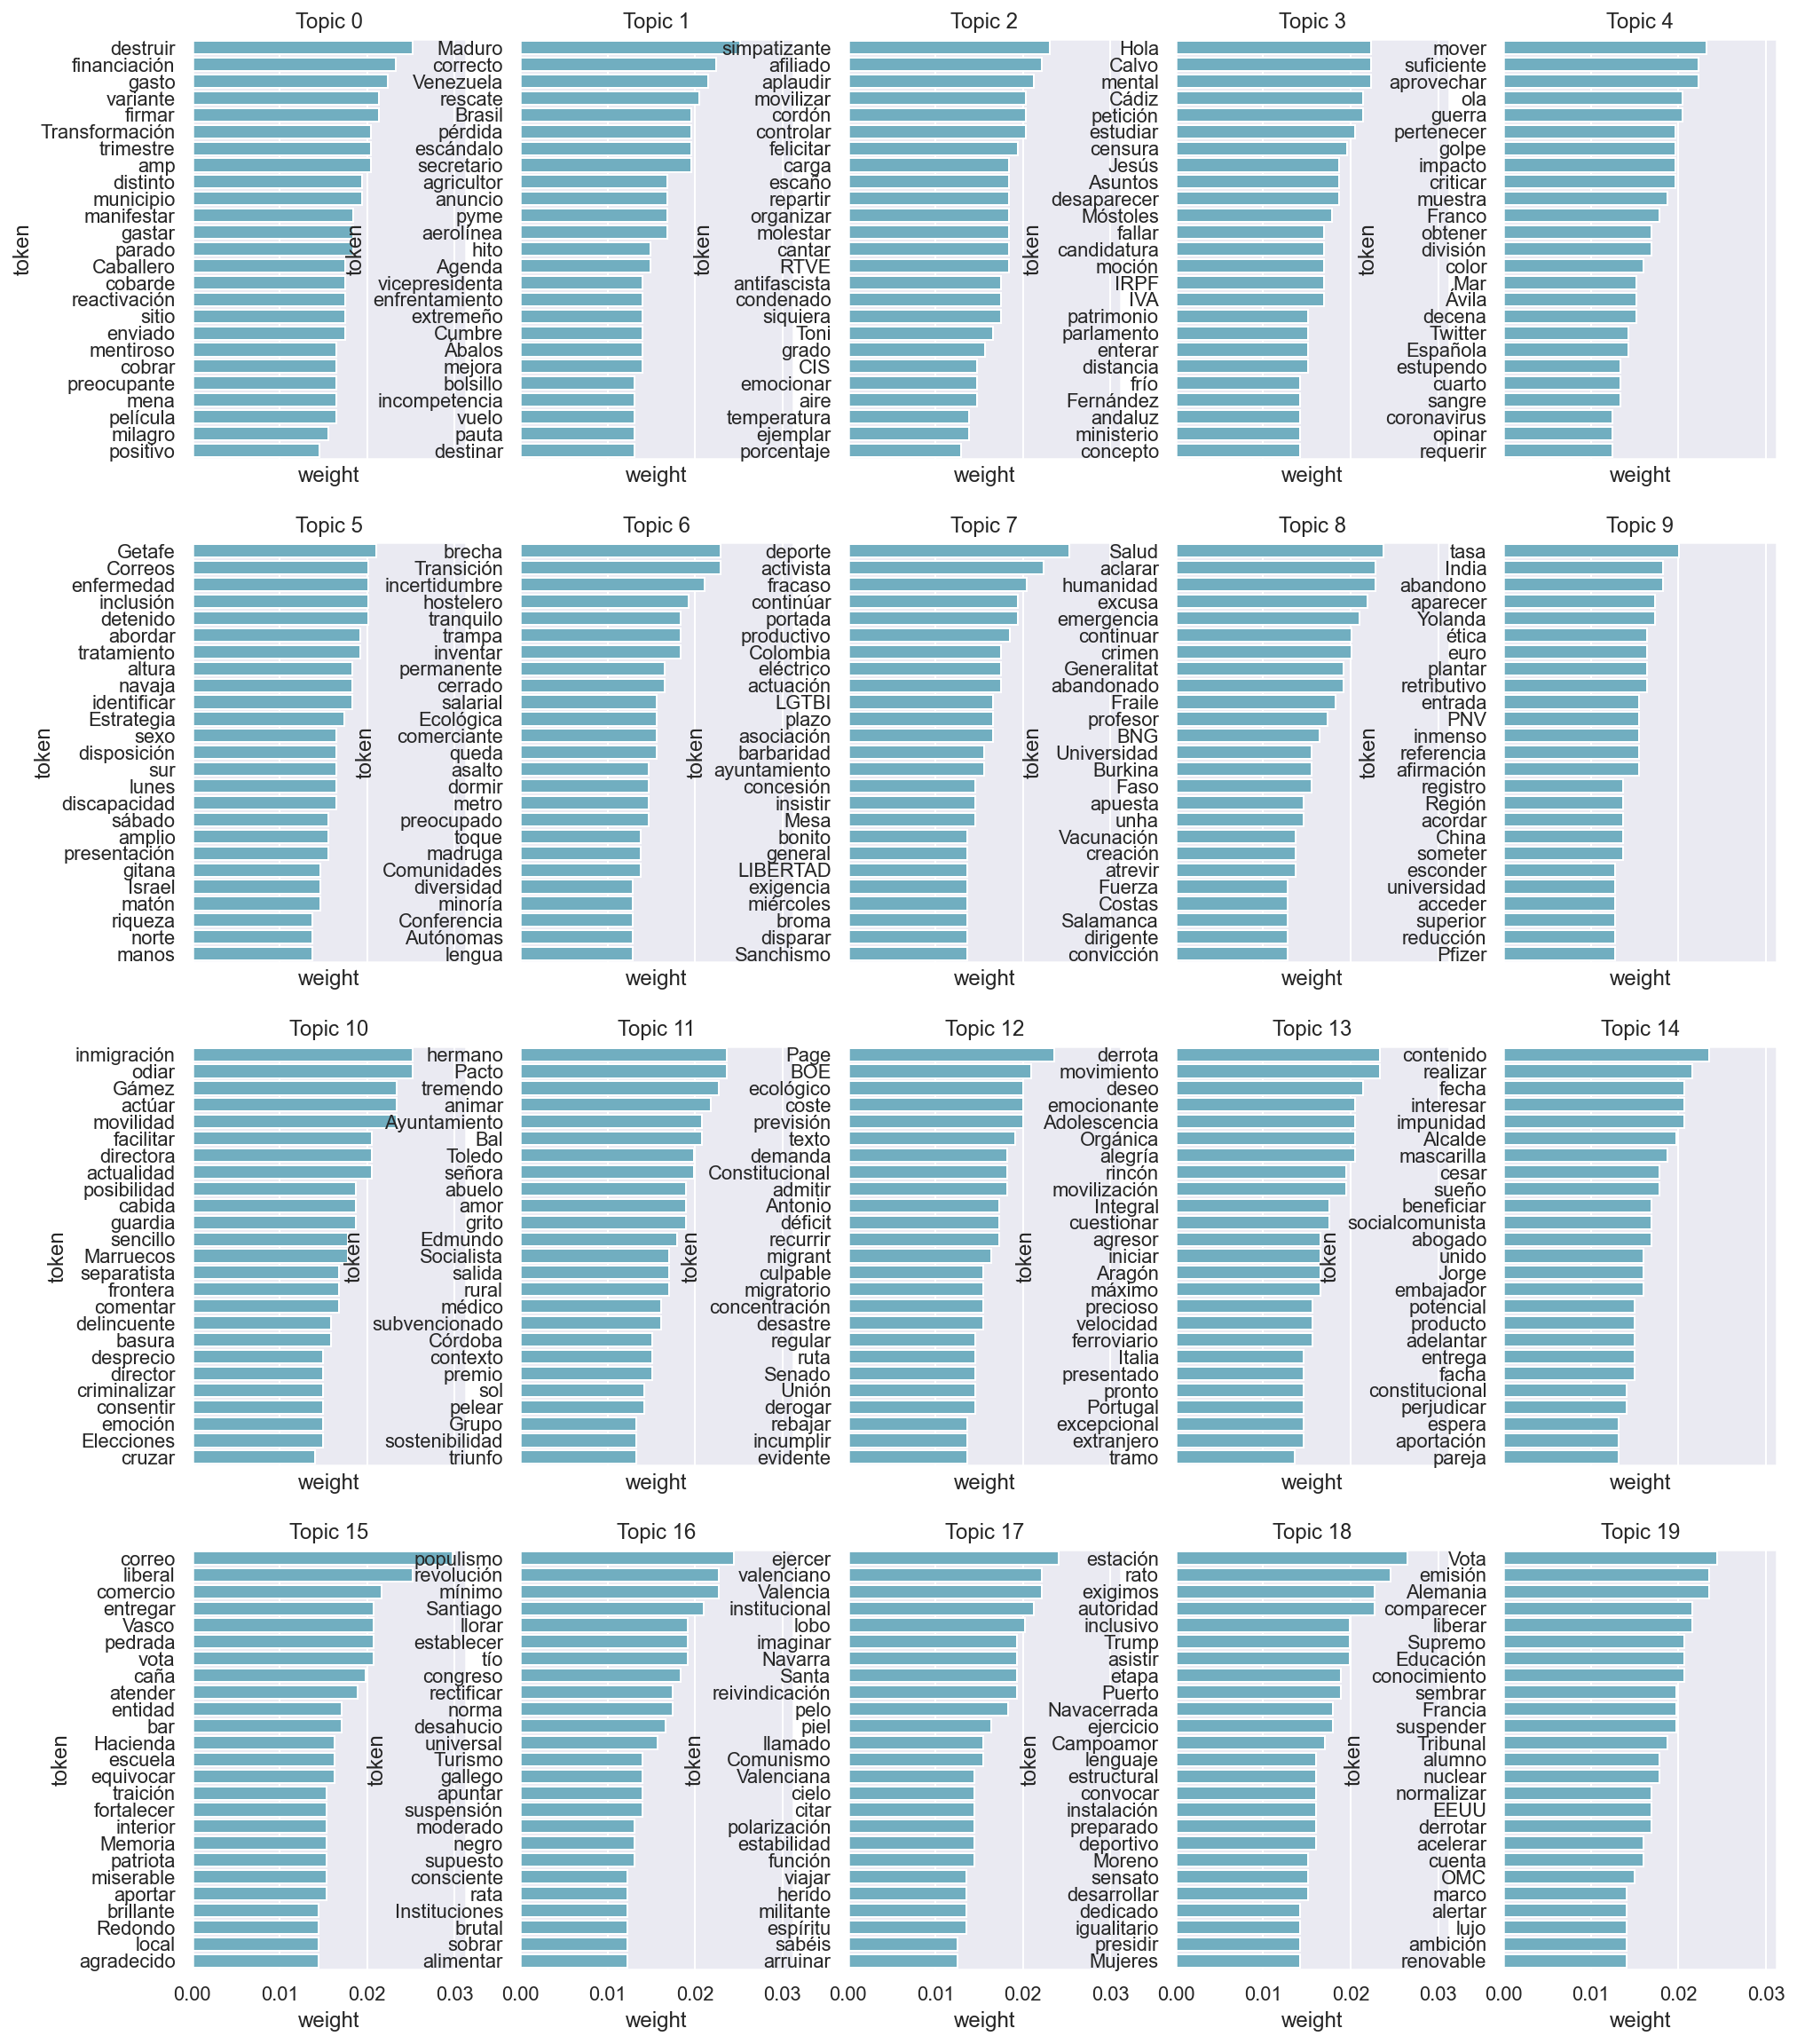

In [22]:
topn = 25

fig, axes = plt.subplots(4, 5, figsize=(16, 20), sharex=True)

for i in range(5):

    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[0][i])
    axes[0][i].set_title('Topic ' + str(i))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 5
    df = pd.DataFrame(ldamallet.show_topic(i+5, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[1][i])
    axes[1][i].set_title('Topic ' + str(i+5))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 10
    df = pd.DataFrame(ldamallet.show_topic(i+10, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[2][i])
    axes[2][i].set_title('Topic ' + str(i+10))
    # Build a dataframe with columns 'token' and 'weight' for topic i + 15
    df = pd.DataFrame(ldamallet.show_topic(i + 15, topn=topn), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[3][i])
    axes[3][i].set_title('Topic ' + str(i + 15))
    
plt.show()

In [ ]:
train_vecs = []

for i in range(len(data)):
    top_topics = ldamallet.get_document_topics(train_corpus[i], minimum_probability=0.0)
    lda_topics_vector = [top_topics[i][1] for i in range(number_of_topics)]
    lda_topics_vector.extend([my_dataframe.iloc[i].favs])  # count of favs
    lda_topics_vector.extend([len(my_dataframe.iloc[i].retweets)])  # count of retweets
    train_vecs.append(topic_vec)
